# **COLLEGE EVENT FEEDBACK ANALYSIS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import io

# Download NLTK data for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('student.csv')
data.head(20)


Saving student.csv to student (2).csv


,Unnamed: 0,Student ID,Well versed with the subject,Explains concepts in an understandable way,Use of presentations,Degree of difficulty of assignments,Solves doubts willingly,Structuring of the course,Provides support for students going above and beyond,Course recommendation based on relevance
0,0,340,5,2,7,6,9,2,1,8
1,1,253,6,5,8,6,2,1,2,9
2,2,680,7,7,6,5,4,2,3,1
3,3,806,9,6,7,1,5,9,4,6
4,4,632,8,10,8,4,6,6,9,9
5,5,832,7,2,7,8,3,5,1,4
6,6,772,9,3,5,2,10,3,8,1
7,7,961,9,8,7,4,4,3,3,10
8,8,814,6,5,8,6,4,4,7,9
9,9,863,5,9,4,7,9,4,4,5


In [ ]:
data = data.drop(columns=['Unnamed: 0'])
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 Student ID                                              0
Well versed with the subject                            0
Explains concepts in an understandable way              0
Use of presentations                                    0
Degree of difficulty of assignments                     0
Solves doubts willingly                                 0
Structuring of the course                               0
Provides support for students going above and beyond    0
Course recommendation based on relevance                0
dtype: int64


In [ ]:
data.columns = ['Student_ID', 'Subject_Knowledge', 'Explanation_Clarity', 'Presentation_Use',
                'Assignment_Difficulty', 'Doubt_Resolution', 'Course_Structure',
                'Advanced_Support', 'Course_Recommendation']

print("\nSummary Statistics:\n", data.describe())



Summary Statistics:
         Student_ID  Subject_Knowledge  Explanation_Clarity  Presentation_Use  \
count  1001.000000        1001.000000          1001.000000       1001.000000   
mean    500.000000           7.497502             6.081918          5.942058   
std     289.108111           1.692998             2.597168          1.415853   
min       0.000000           5.000000             2.000000          4.000000   
25%     250.000000           6.000000             4.000000          5.000000   
50%     500.000000           8.000000             6.000000          6.000000   
75%     750.000000           9.000000             8.000000          7.000000   
max    1000.000000          10.000000            10.000000          8.000000   

       Assignment_Difficulty  Doubt_Resolution  Course_Structure  \
count            1001.000000       1001.000000       1001.000000   
mean                5.430569          5.474525          5.636364   
std                 2.869046          2.874648       

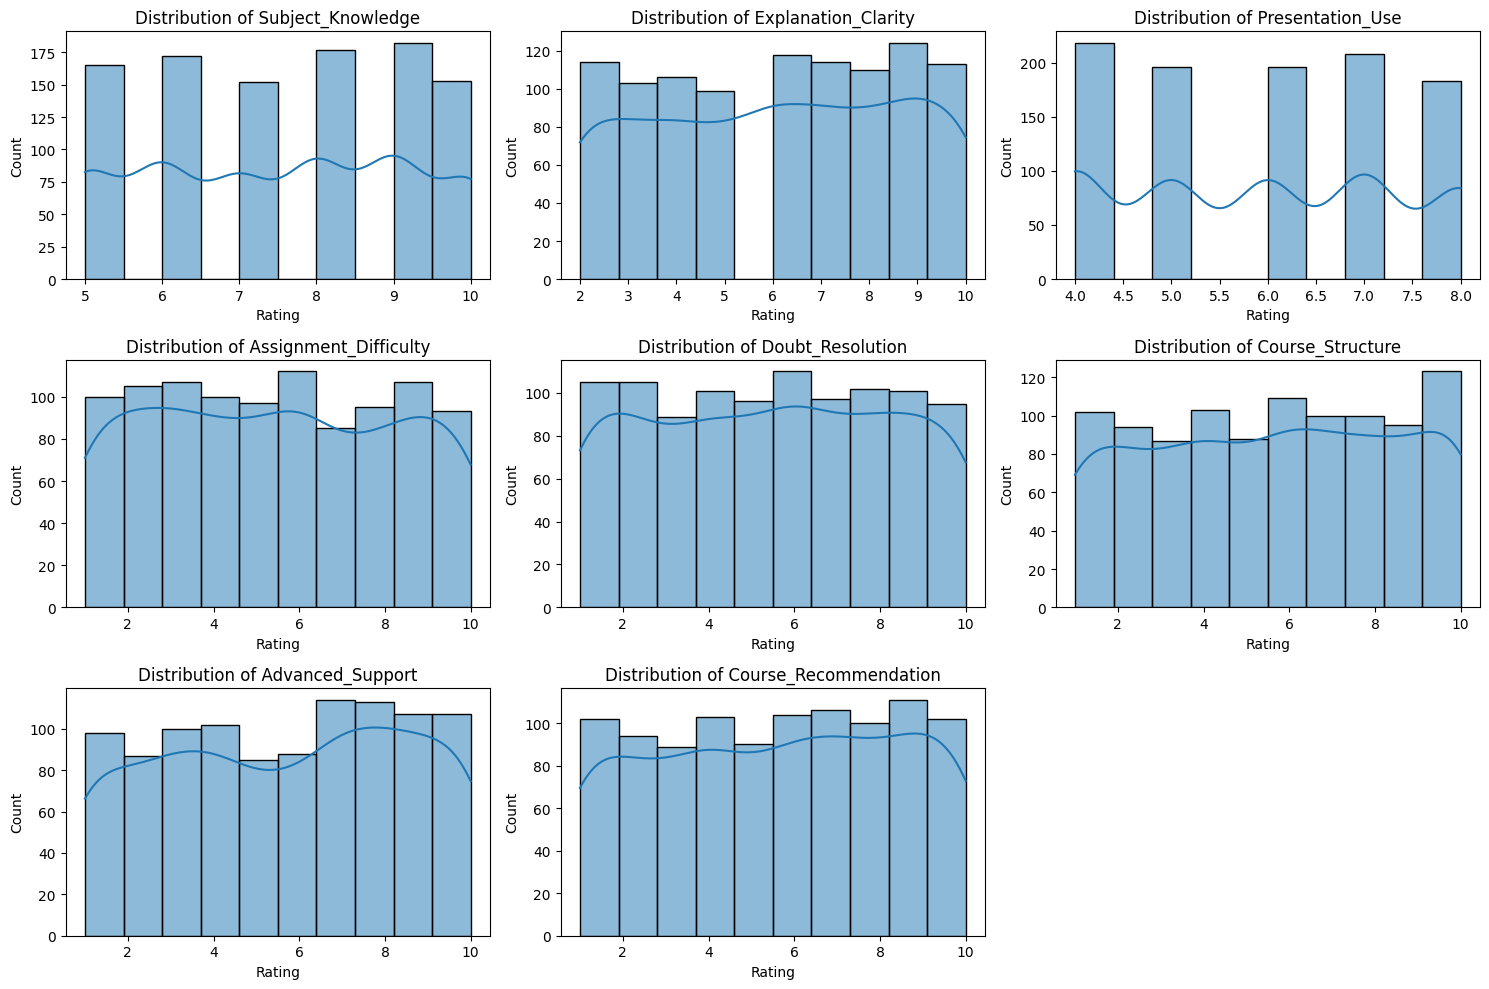

In [ ]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], bins=10, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Rating')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

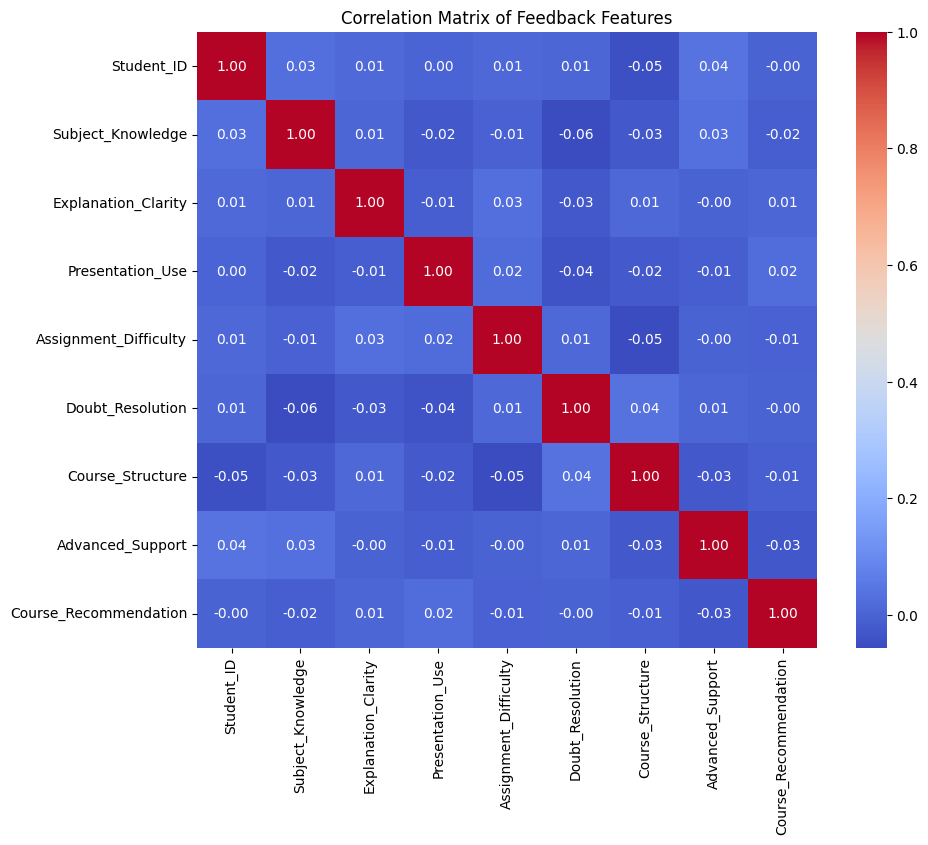

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Feedback Features')
plt.show()

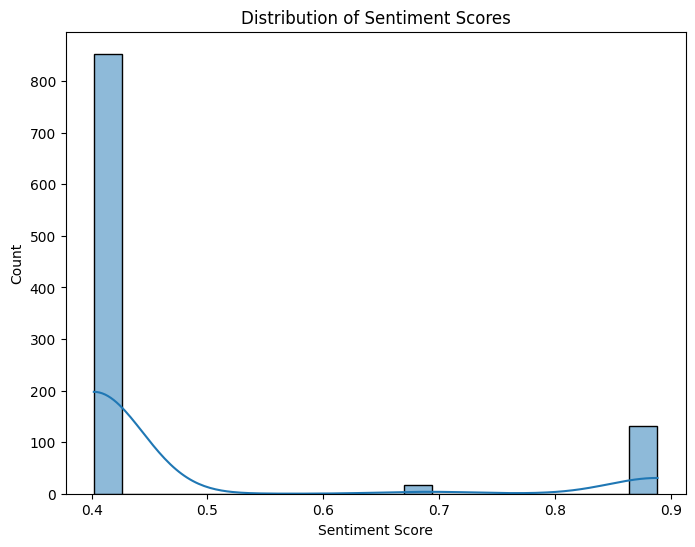

In [ ]:
def rating_to_sentiment(row):
    avg_rating = row[['Subject_Knowledge', 'Explanation_Clarity', 'Presentation_Use',
                      'Assignment_Difficulty', 'Doubt_Resolution', 'Course_Structure',
                      'Advanced_Support']].mean()
    if avg_rating > 7:
        return f"The course was great with excellent {row['Subject_Knowledge']} subject knowledge and {row['Explanation_Clarity']} clarity in explanations."
    elif avg_rating >= 4:
        return f"The course was decent with {row['Subject_Knowledge']} subject knowledge and {row['Explanation_Clarity']} clarity."
    else:
        return f"The course needs improvement in {row['Subject_Knowledge']} subject knowledge and {row['Explanation_Clarity']} clarity."

data['Text_Feedback'] = data.apply(rating_to_sentiment, axis=1)

sid = SentimentIntensityAnalyzer()
data['Sentiment_Score'] = data['Text_Feedback'].apply(lambda x: sid.polarity_scores(x)['compound'])

plt.figure(figsize=(8, 6))
sns.histplot(data['Sentiment_Score'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()



In [ ]:
# Predicting Course_Recommendation (treating it as a binary classification: recommend (>=6) or not (<6))
data['Recommendation_Label'] = data['Course_Recommendation'].apply(lambda x: 1 if x >= 6 else 0)

# Features and target
X = data[['Subject_Knowledge', 'Explanation_Clarity', 'Presentation_Use',
          'Assignment_Difficulty', 'Doubt_Resolution', 'Course_Structure', 'Advanced_Support']]
y = data['Recommendation_Label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_test_scaled)

# Evaluating the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)


Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.39      0.40        94
           1       0.49      0.50      0.50       107

    accuracy                           0.45       201
   macro avg       0.45      0.45      0.45       201
weighted avg       0.45      0.45      0.45       201


Confusion Matrix:
 [[37 57]
 [53 54]]

Feature Importance:
                  Feature  Importance
4       Doubt_Resolution    0.159736
5       Course_Structure    0.156896
6       Advanced_Support    0.154968
3  Assignment_Difficulty    0.150281
1    Explanation_Clarity    0.148651
0      Subject_Knowledge    0.121812
2       Presentation_Use    0.107657


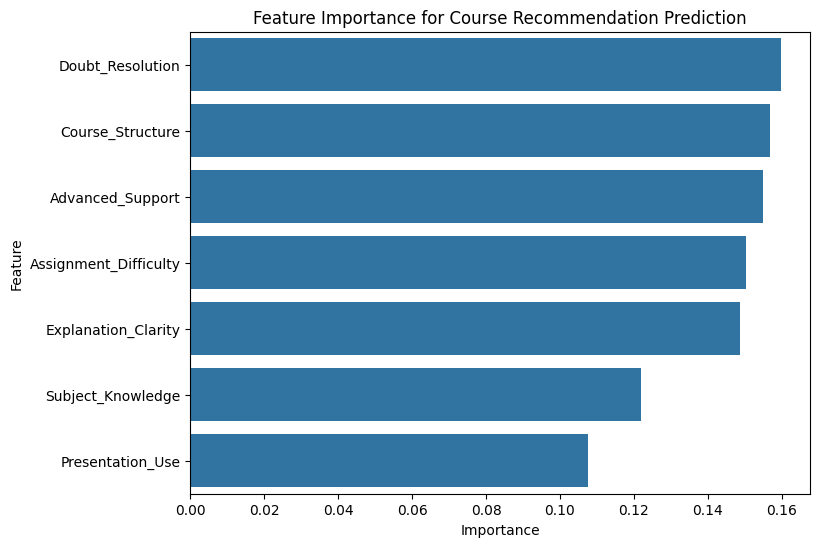

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Course Recommendation Prediction')
plt.show()

In [ ]:
print("\nKey Insights:")
print("- The distribution of ratings shows that most features have a wide range of scores, indicating varied student experiences.")
print("- Sentiment analysis reveals that courses with higher average ratings (>7) are perceived positively.")
print("- The Random Forest model indicates that features like Subject Knowledge and Explanation Clarity are strong predictors of course recommendation.")
print("\nRecommendations:")
print("- Focus on improving Explanation Clarity and Subject Knowledge, as they significantly influence course recommendation.")
print("- Consider adjusting assignment difficulty, as it may impact student satisfaction.")
print("- Enhance support for students going above and beyond to increase overall course appeal.")


Key Insights:
- The distribution of ratings shows that most features have a wide range of scores, indicating varied student experiences.
- Sentiment analysis reveals that courses with higher average ratings (>7) are perceived positively.
- The Random Forest model indicates that features like Subject Knowledge and Explanation Clarity are strong predictors of course recommendation.

Recommendations:
- Focus on improving Explanation Clarity and Subject Knowledge, as they significantly influence course recommendation.
- Consider adjusting assignment difficulty, as it may impact student satisfaction.
- Enhance support for students going above and beyond to increase overall course appeal.
